# Library


In [1]:
import talib
import talib.abstract as ta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

2023-11-08 16:29:17.570567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 16:29:17.907827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 16:29:17.907855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 16:29:17.910111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 16:29:18.067734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 16:29:18.069371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load Data

In [2]:
# path
ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


# get all ticker name
def ticker_name(data_ticker):
    return data_ticker['ticker'].unique().tolist()

# get data of a specific ticker
def take_data_ticker(data_ticker, name_ticker):
    data_source = []
    for ticker in name_ticker:
        filtered_data = data_ticker[data_ticker['ticker'] == ticker]
        data_source.append(filtered_data)
    return data_source


# code_ticker_taken = ticker_data['ticker'].unique()
code_ticker_taken = ['SSI','SHS','HPG','HSG','TCB']

data_full = take_data_ticker(ticker_data, code_ticker_taken)

/tmp/ipykernel_622/1068416681.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


# Technical Indicator

In [3]:
# h = high
# l = low
# o = open
# c = close
# v = vol

indicators = talib.get_functions()
indicators.remove('AD')
indicators.remove('ADOSC')
indicators.remove('MFI')
indicators.remove('OBV')

hlcv_indicators = ['AD','ADOSC','MFI']
cl_indicators = ['OBV']


data_with_indi = []

for data in data_full:
    data = data.copy()
    for indicator in indicators:

        # indi need 1 value
        try: 
            name = ta.Function(indicator)(data['close'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass

        # indi need 2 value
        try: 
            name = ta.Function(indicator)(data['high'],data['low'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass 

        # indi need 3 value       
        try:
            name = ta.Function(indicator)(data['high'],data['low'],data['close'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass

        # indi need 4 value
        try: 
            name = ta.Function(indicator)(data['open'],data['high'],data['low'],data['close'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass
    
    # others indi that need specific value
    for hlcv_indicator in hlcv_indicators:
        try: 
            name = ta.Function(hlcv_indicator)(data['open'],data['high'],data['close'],data['volume'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass 
    for cl_indicator in cl_indicators:
        try: 
            name = ta.Function(cl_indicator)(data['close'],data['volume'])
            if len(name)>100:
                data[indicator] = name
            else:
                for i in range(len(name)):
                    data[indicator] = name[i]
        except Exception as e:
            pass 
    data_with_indi.append(data)
    

data_full = []

/tmp/ipykernel_622/3003083758.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[indicator] = name
/tmp/ipykernel_622/3003083758.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[indicator] = name
/tmp/ipykernel_622/3003083758.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i

In [4]:
data_with_indi[0].head()

,time,open,high,low,close,volume,ticker,industry,HT_DCPERIOD,HT_DCPHASE,...,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ATR,NATR,TRANGE
0,2018-10-29,12500,12530,12320,12460,1971190,SSI,Dịch vụ tài chính,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1971190.0
1,2018-10-30,12500,12800,12340,12500,1967410,SSI,Dịch vụ tài chính,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3938600.0
2,2018-10-31,12730,13090,12660,13030,2418880,SSI,Dịch vụ tài chính,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6357480.0
3,2018-11-01,13070,13090,12710,12730,2372190,SSI,Dịch vụ tài chính,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3985290.0
4,2018-11-02,12840,13180,12780,13090,3357100,SSI,Dịch vụ tài chính,NaN,NaN,...,NaN,NaN,NaN,NaN,260.875449,NaN,68056.0,NaN,NaN,7342390.0


# Prepare Data


Convert industry to one-hot encoding

In [5]:
# industry = pd.get_dummies(data['industry'], drop_first = True)
# data = pd.concat([data, industry], axis = 1)
# data.drop(['industry'], axis = 1, inplace = True)

Remove Unnecessary Feature

In [6]:
data_model = []

for data in data_with_indi:
    try:
        # remove name
        data = data.drop("time", axis=1)
        data = data.drop("ticker", axis=1)
        data = data.drop("industry", axis=1)
        data = data.drop("high", axis=1)
        data = data.drop("low", axis=1)
        data = data.drop("open", axis=1)
        data = data.drop("volume", axis=1)
        data = data.drop("ACOS", axis=1)
        data = data.drop("ASIN", axis=1)
        data = data.drop("COSH", axis=1)
        data = data.drop("EXP", axis=1)
        data = data.drop("SINH", axis=1)
        data = data.fillna(method="ffill").fillna(method="bfill")
    except Exception as e:
        pass

    data_model.append(data)

data_with_indi = []

/tmp/ipykernel_622/1893896651.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


/tmp/ipykernel_622/1893896651.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_622/1893896651.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_622/1893896651.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_622/1893896651.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


Check Infinity Value

In [7]:
for df in data_model:
    numeric_columns = df.select_dtypes(include=["number"])
    columns_with_infinity = []
    for col in numeric_columns.columns:
        if any(np.isinf(df[col])):
            columns_with_infinity.append(col)

    print("Columns with Infinity Values:")
    print(columns_with_infinity)

Columns with Infinity Values:
[]
Columns with Infinity Values:
[]
Columns with Infinity Values:
[]
Columns with Infinity Values:
[]
Columns with Infinity Values:
[]


Create Target

- 1 day
- 3 day
- 5 day
- 10 day

In [8]:
data_target = []

for data in data_model:
    data['close_1'] = data['close'].shift(-1)
    data['close_3'] = data['close'].shift(-3)
    data['close_5'] = data['close'].shift(-5)
    data['close_10'] = data['close'].shift(-10)
    
    data.drop(data.tail((len(data.index) - 126) % 21).index, inplace=True)
    data = data.drop("close", axis=1)
    data_target.append(data)


data_model = []

/tmp/ipykernel_622/2460292562.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['close_1'] = data['close'].shift(-1)
/tmp/ipykernel_622/2460292562.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['close_3'] = data['close'].shift(-3)
/tmp/ipykernel_622/2460292562.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [9]:
nan_locations = data.isna()
nan_counts = nan_locations.sum().sum()

print(nan_counts)

0


Correlation Matrix

In [10]:
# Set a correlation threshold
correlation_threshold = 0.95

data_prevent = []

for df in data_model:
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Find pairs of columns with correlation greater than the threshold
    high_corr_pairs = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (
                correlation_matrix.columns[i] != "close"
                and correlation_matrix.columns[j] != "close"
                and abs(correlation_matrix.iloc[i, j]) > correlation_threshold
            ):
                colname1 = correlation_matrix.columns[i]
                colname2 = correlation_matrix.columns[j]
                high_corr_pairs.add((colname1, colname2))

    # Create a list of columns to remove
    columns_to_remove = set()
    for col1, col2 in high_corr_pairs:
        columns_to_remove.add(col2)

    # Drop the columns with high correlation (except 'close')
    df_filtered = df.drop(columns=list(columns_to_remove))

    # Display the DataFrame with high-correlation columns removed
    print("DataFrame with High-Correlation Columns Removed:")
    print(df_filtered)
    data_prevent.append(df_filtered)
    print(df_filtered.shape)

Split Data

In [11]:
# split train and test data

train_day = 21 * 6  # 6 month
test_day = 21  # 1 month
num_set = (len(data.index) - 126) // 21  # num of dataset

print(num_set)
sum_train = []
sum_test = []

for data in data_target:
    train_set = []
    test_set = []
    for i in range(num_set):
        set_train = data.iloc[test_day * i : train_day + test_day * i]
        set_test = data.iloc[train_day + test_day * i : train_day + test_day * (i + 1)]
        train_set.append(set_train)
        test_set.append(set_test)
    sum_train.append(train_set)
    sum_test.append(test_set)



53


# Model

Linear Regression

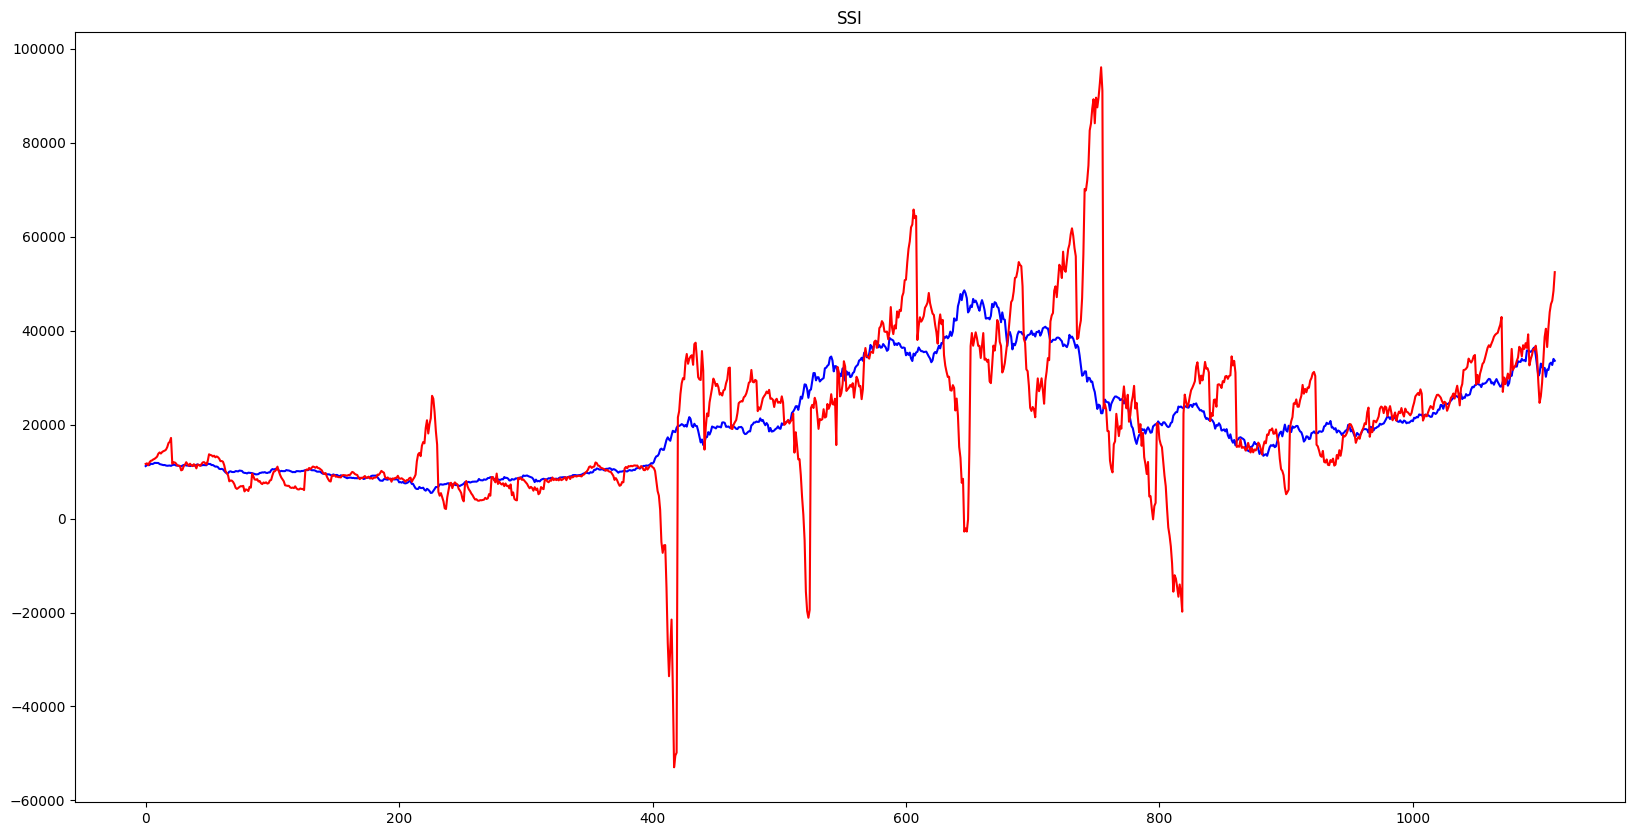

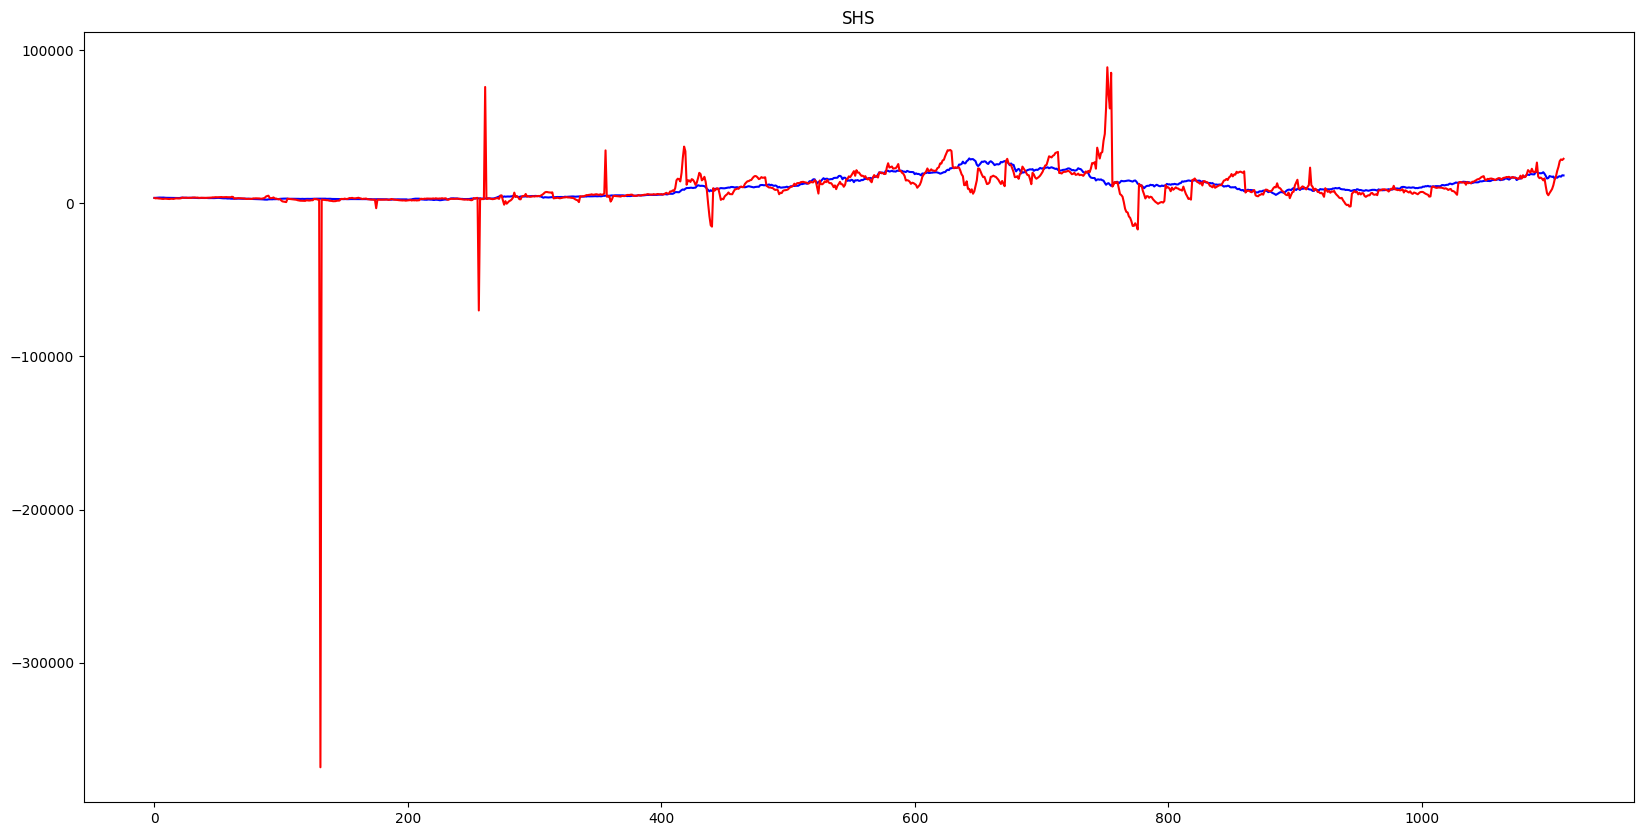

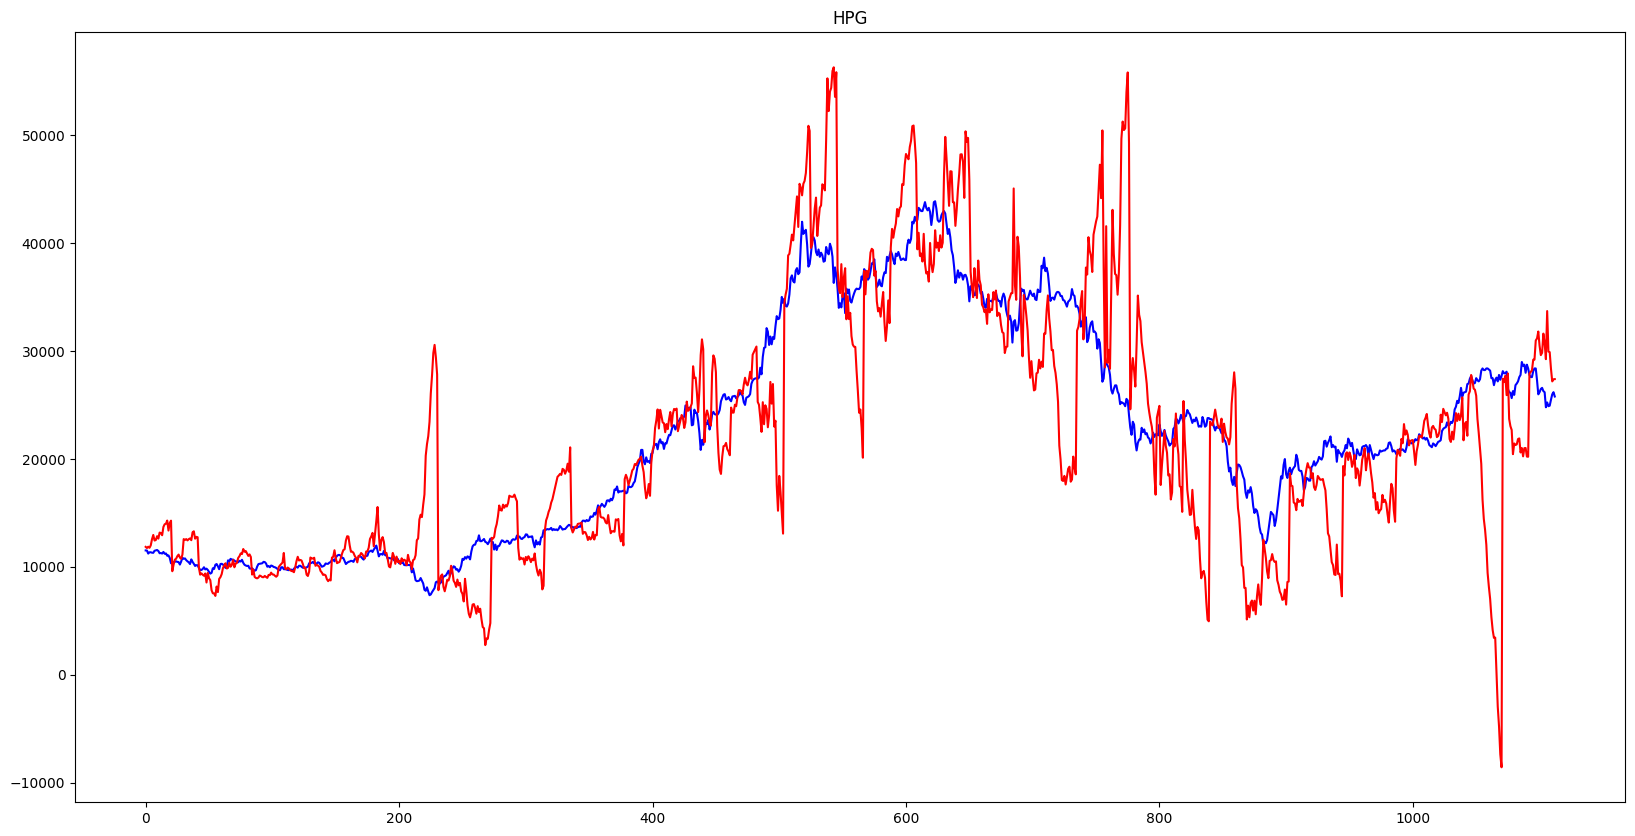

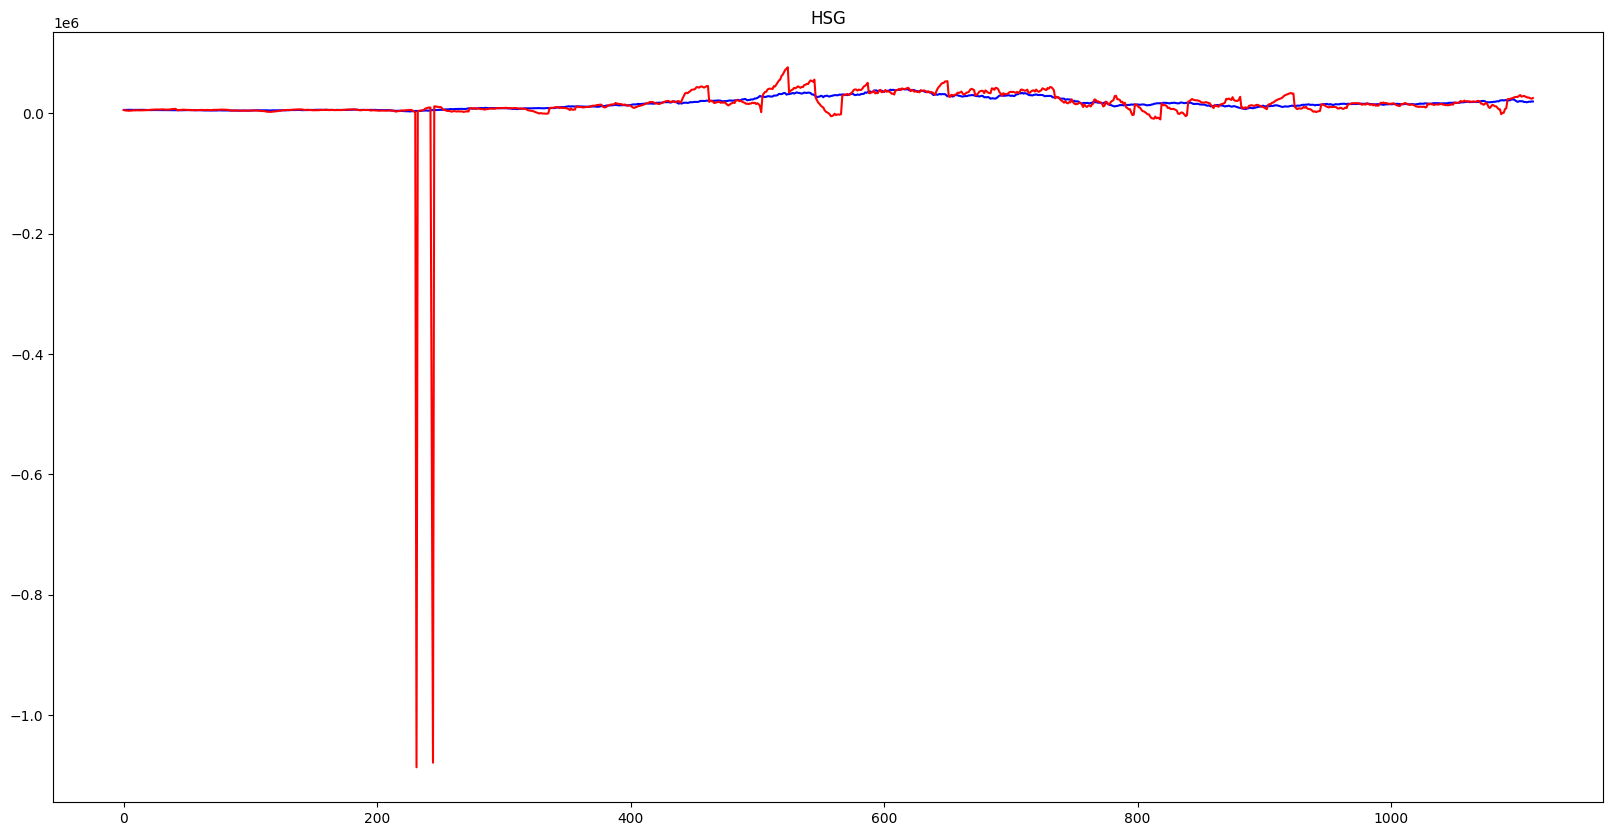

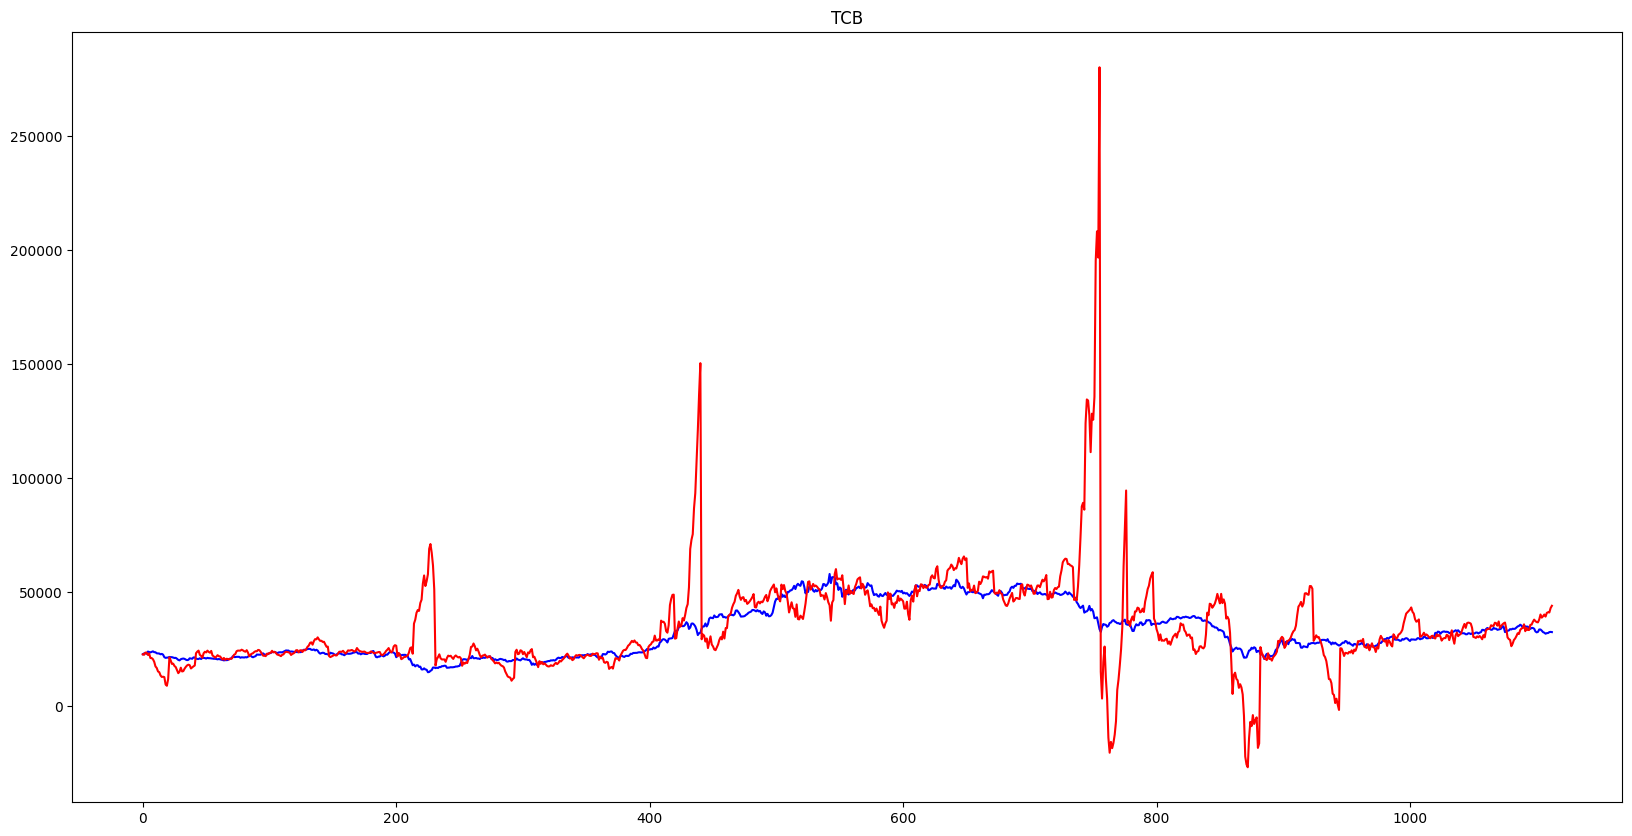

In [13]:
pred_LR_1D = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):

        # target
        target_col = ['close_1', 'close_3','close_5','close_10']

        # train 
        Y_train = sum_train[i][j]['close_1'].to_numpy()
        X_train = sum_train[i][j].drop(columns=target_col, axis=1).to_numpy()

        # test
        y_test = sum_test[i][j]['close_1']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop(columns=target_col, axis=1).to_numpy()

        # model 
        model = LinearRegression().fit(X_train, Y_train)
        y_pred = model.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_LR_1D.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    # print(mae)
    # print(rmse)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual', color='blue')  # Blue color
    plt.plot(y_pred_all, label='Predict', color='red') # Red color
    plt.title(code_ticker_taken[i])    

Random Forest

1382.394438454627
2400.055476179974


KeyboardInterrupt: 

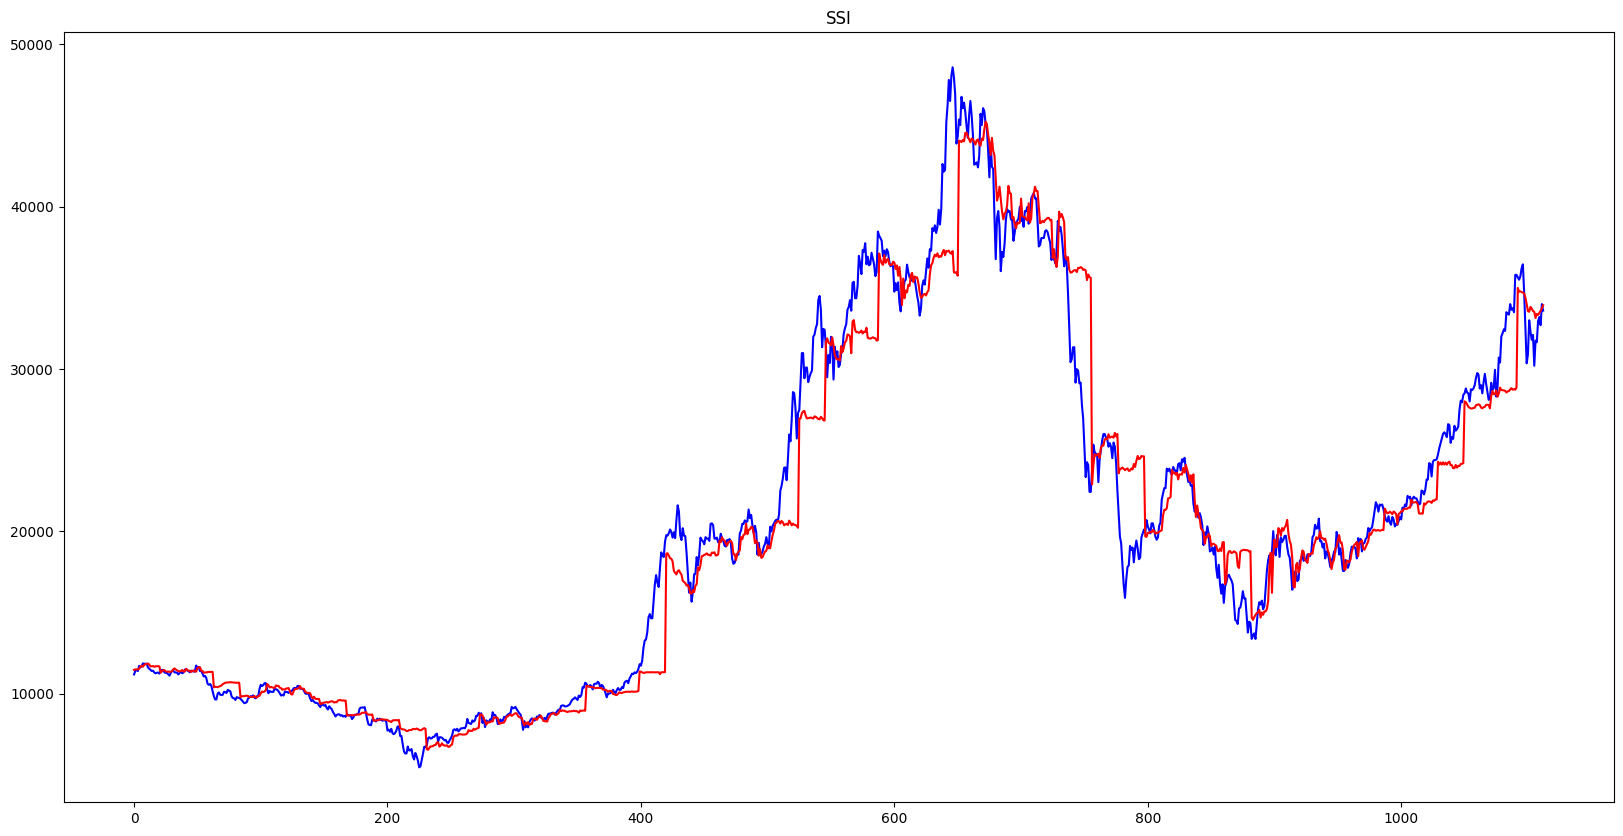

In [14]:
pred_y_RF_1D = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):

        # target
        target_col = ['close_1', 'close_3','close_5','close_10']

        # train 
        Y_train = sum_train[i][j]['close_1'].to_numpy()
        X_train = sum_train[i][j].drop(columns=target_col, axis=1).to_numpy()

        # test
        y_test = sum_test[i][j]['close_1']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop(columns=target_col, axis=1).to_numpy()

        # model 
        model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
        model.fit(X_train, Y_train)
        y_pred = model.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y_RF_1D.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    print(mae)
    print(rmse)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual', color='blue')  # Blue color
    plt.plot(y_pred_all, label='Predict', color='red') # Red color
    plt.title(code_ticker_taken[i])    

XGBoost


In [22]:
import xgboost as xgb


pred_y = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):

        # target
        target_col = ['close_1', 'close_3','close_5','close_10']

        # train 
        Y_train = sum_train[i][j]['close_1'].to_numpy()
        X_train = sum_train[i][j].drop(columns=target_col, axis=1).to_numpy()

        # test
        y_test = sum_test[i][j]['close_1']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop(columns=target_col, axis=1).to_numpy()

        # model 
        model = xgb.XGBClassifier()
        model.fit(X_train, Y_train)
        y_pred = regressor.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual')
    plt.plot(y_pred_all, label='Predict')
    plt.title(code_ticker_taken[i])  

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63], got [11230. 11310. 11430. 11460. 11560. 11590. 11610. 11640. 11680. 11710.
 11730. 11780. 11810. 11840. 11860. 11890. 11910. 12050. 12060. 12110.
 12160. 12180. 12210. 12230. 12280. 12300. 12320. 12340. 12360. 12390.
 12410. 12430. 12480. 12500. 12550. 12590. 12640. 12660. 12680. 12710.
 12730. 12780. 12800. 12820. 12840. 12860. 12910. 12930. 12960. 12980.
 13000. 13030. 13070. 13090. 13130. 13250. 13280. 13300. 13320. 13360.
 13380. 13410. 13480. 13500.]

LightGBM

In [ ]:
import lightgbm as lgb


pred_y = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):

        # target
        target_col = ['close_1', 'close_3','close_5','close_10']

        # train 
        Y_train = sum_train[i][j]['close_1'].to_numpy()
        X_train = sum_train[i][j].drop(columns=target_col, axis=1).to_numpy()

        # test
        y_test = sum_test[i][j]['close_1']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop(columns=target_col, axis=1).to_numpy()

        # model 
        model = lgb.LGBMClassifier(force_col_wise=True)
        model.fit(X_train, Y_train)
        y_pred = model.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual')
    plt.plot(y_pred_all, label='Predict')
    plt.title(code_ticker_taken[i])  